**Outline:**

1. [Libraries and settings](#1-bullet)
2. [Train and Evaluate Model](#2-bullet)
3. [Predictions](#3-bullet)

## 1. [Libraries and settings](#1-bullet)

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score

import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('/Users/trannguyenmyanh/Documents/VietFinanceLab-Analyzing-Market-Trends-and-Forecasting-Future-Price/Dataset/finance/VIG.csv', sep='\t', index_col=0)

df.head()

In [153]:
df['TradingDate'] = pd.to_datetime(df['TradingDate'], format='%Y-%m-%d')

In [154]:
df = df.dropna()

In [155]:
# Create a new dataframe
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values

In [156]:
# scaler = MinMaxScaler(feature_range=(0,1))
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)

In [157]:
scaled_data

array([[-0.06465533],
       [-0.24831638],
       [-0.36421898],
       ...,
       [ 1.79870188],
       [ 1.87002656],
       [ 1.9056889 ]])

## 2. [Train and Evaluate Model](#2-bullet)

### Create dataset

In [158]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [159]:
time_step = 30
x_for_train, y_for_train = create_dataset(scaled_data, time_step)

x_for_train = x_for_train.reshape(x_for_train.shape[0],x_for_train.shape[1])
y_for_train = y_for_train.reshape(y_for_train.shape[0],1)

In [160]:
training_size=int(len(dataset)*0.8)
test_size=len(dataset)-training_size
train_data,test_data=scaled_data[0:training_size],scaled_data[training_size:len(dataset)]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (1398, 1)
test_data:  (350, 1)


In [161]:
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

x_train =x_train.reshape(x_train.shape[0],x_train.shape[1])
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1])
y_train = y_train.reshape(y_train.shape[0],1)
y_test = y_test.reshape(y_test.shape[0],1)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_test: ", x_test.shape)
print("y_test", y_test.shape)

x_train:  (1367, 30)
y_train:  (1367, 1)
x_test:  (319, 30)
y_test (319, 1)


### Building model

Using best hyperparameters after tuning to retrain model

In [162]:
# Create and train the SVR model
svr_model = SVR(C = 1, kernel = 'linear', gamma = 0.01)
svr_model.fit(x_train, y_train)

SVR(C=1, gamma=0.01, kernel='linear')

In [163]:
predictions = svr_model.predict(x_test)
predictions = predictions.reshape(-1,1)

predictions_train = svr_model.predict(x_train)
predictions_train = predictions_train.reshape(-1,1)

In [164]:
predictions = scaler.inverse_transform(predictions)
predictions_train = scaler.inverse_transform(predictions_train)
y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

In [165]:
column_names_pred = ['Close_predict']
df_predictions = pd.DataFrame(predictions, columns=column_names_pred)

column_names_test = ['Close_test']
df_test = pd.DataFrame(y_test, columns=column_names_test)

concatenated = np.concatenate([df_predictions, df_test], axis=1)
column_names_concat = ['Close_predict', 'Close_test']
df_concatenated = pd.DataFrame(concatenated, columns = column_names_concat)

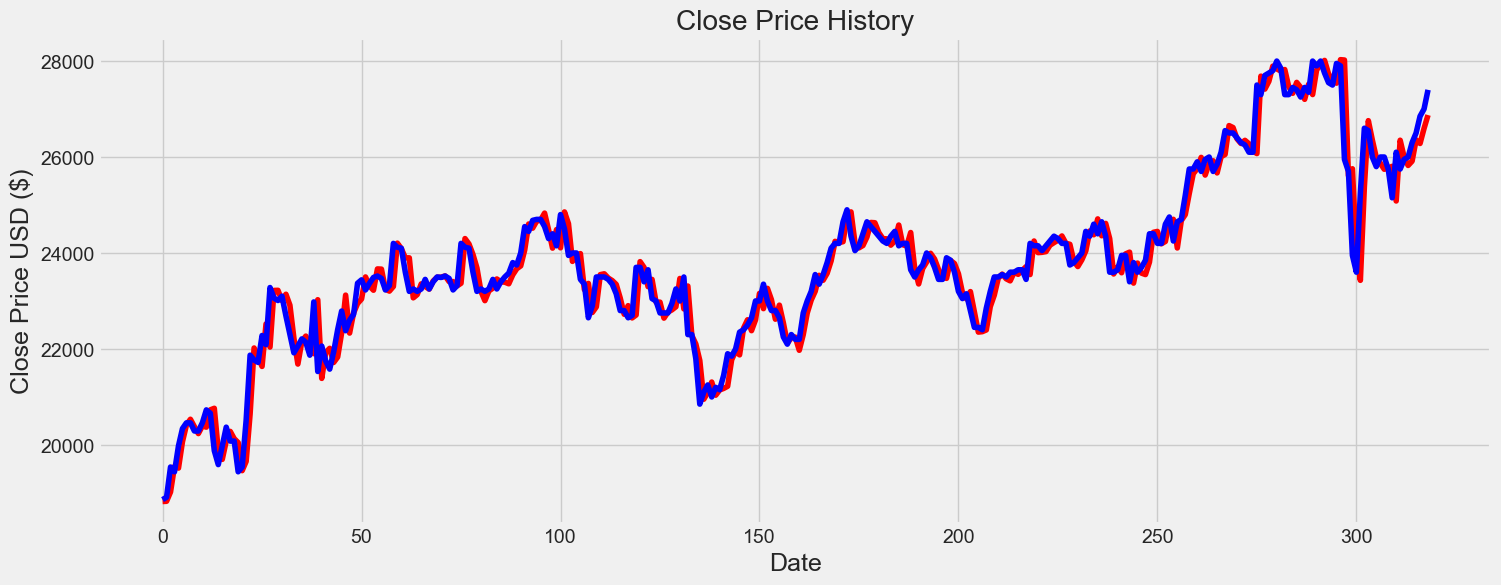

In [166]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df_predictions['Close_predict'], color='red', label='Predicted Close Price')
plt.plot(df_test['Close_test'], color='blue', label='Actual Close Price')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

### Evaluate model

In [167]:
predictions = scaler.fit_transform(predictions)
predictions_train = scaler.fit_transform(predictions_train)
y_test = scaler.fit_transform(y_test)
y_train = scaler.fit_transform(y_train)

In [168]:
mae_train = mean_absolute_error(y_train, predictions_train)
rmse_train = mean_squared_error(y_train, predictions_train)
r2_train = r2_score(y_train, predictions_train)

print("Train Mean Absolute Error:", mae_train)
print("Train Mean Squared Error:", rmse_train)
print("Train R-squared:", r2_train)

Train Mean Absolute Error: 0.04586614889473083
Train Mean Squared Error: 0.004361670409744454
Train R-squared: 0.9956383295902556


In [169]:
mae_test = mean_absolute_error(y_test, predictions)
rmse_test = mean_squared_error(y_test, predictions)
r2_test = r2_score(y_test, predictions)

print("Test Mean Absolute Error:", mae_test)
print("Test Mean Squared Error:", rmse_test)
print("Test R-squared:", r2_test)

Test Mean Absolute Error: 0.1499426124899355
Test Mean Squared Error: 0.04886216926695745
Test R-squared: 0.9511378307330426


## 3. [Predictions](#4-bullet)

In [170]:
predictions = scaler.inverse_transform(predictions)
predictions_train = scaler.inverse_transform(predictions_train)
y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

In [171]:
last_60_days = np.array([y_test[i] for i in range(-1, -61, -1)])
next_days = []
for i in range(60):
    input_data = x_test[i-60].reshape(-1,30)

    predicted_price = svr_model.predict(input_data)
    next_days.append(predicted_price)

#
# pop_price = next_days.pop(0)
print("Predicted prices for the next days:")

for i, price in enumerate(next_days):
    price = scaler.inverse_transform(price.reshape(-1,1))
    print(f"Day {i+1}: {price}")

next_days = scaler.inverse_transform(np.array(next_days).reshape(-1,1))

Predicted prices for the next days:
Day 1: [[23269.15738104]]
Day 2: [[23366.84085553]]
Day 3: [[23577.82006377]]
Day 4: [[23244.32733324]]
Day 5: [[23462.15293467]]
Day 6: [[23513.46097961]]
Day 7: [[23284.7810005]]
Day 8: [[23590.79334385]]
Day 9: [[23633.3378127]]
Day 10: [[24178.26945599]]
Day 11: [[24141.35126172]]
Day 12: [[23929.09485633]]
Day 13: [[23840.91755726]]
Day 14: [[23899.61965708]]
Day 15: [[23835.33985971]]
Day 16: [[23697.20197143]]
Day 17: [[23650.32537844]]
Day 18: [[25112.44460779]]
Day 19: [[24868.15233716]]
Day 20: [[25013.18795408]]
Day 21: [[25301.05712049]]
Day 22: [[25247.8879195]]
Day 23: [[25210.54153404]]
Day 24: [[25237.38417673]]
Day 25: [[24912.38711606]]
Day 26: [[24788.35646875]]
Day 27: [[24994.65292266]]
Day 28: [[24900.64867725]]
Day 29: [[24674.84295598]]
Day 30: [[24959.23932414]]
Day 31: [[24764.96916406]]
Day 32: [[25229.91907688]]
Day 33: [[25330.28434351]]
Day 34: [[25409.65290108]]
Day 35: [[25156.9976682]]
Day 36: [[25029.91322346]]
Day 3

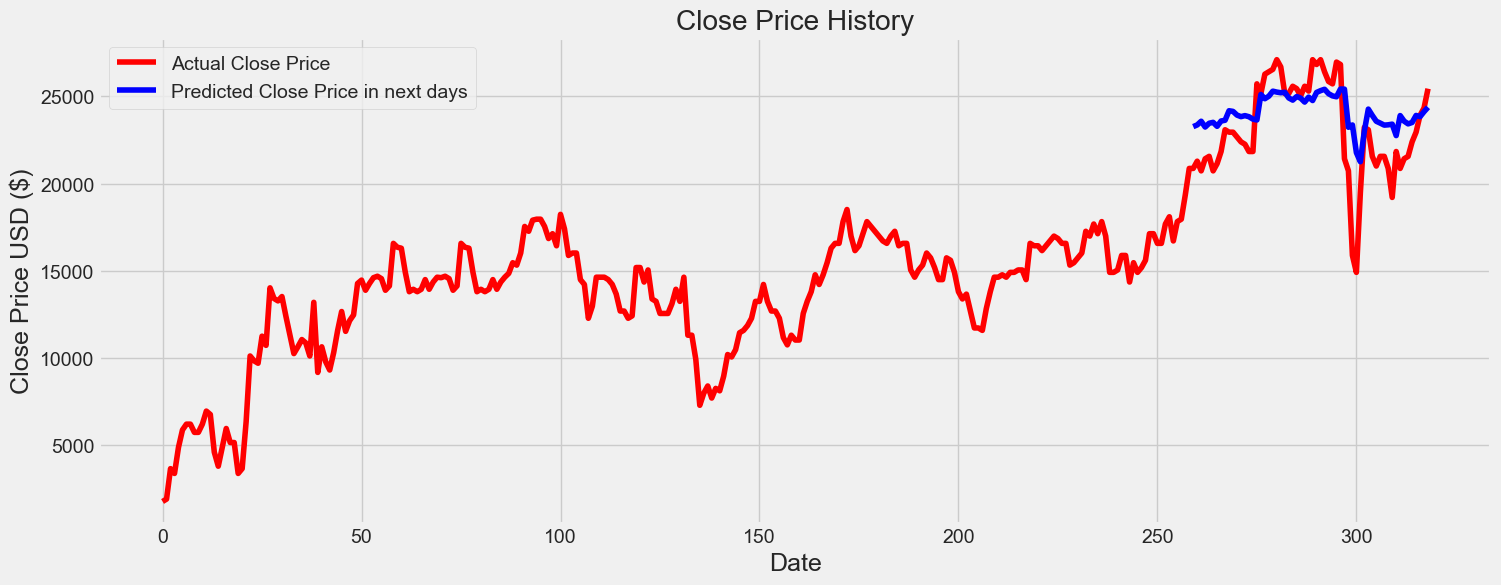

In [172]:
plt.figure(figsize=(16, 6))
plt.title('Close Price History')
plt.plot(y_test[:], color='red', label='Actual Close Price')
plt.plot(range(len(y_test)-60, len(y_test)), next_days, color='blue', label='Predicted Close Price in next days')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.legend()
plt.show()